# Heat Diffusion Example using Cellular Automaton
This module corresponds with Module 10.2 of Angela B. and George W Shiflet's book [Introduction to Computational Science](https://ics.wofford-ecs.org/).  We will develop a simple simulation of 2D time dependent heat transfer using cellular automaton techniques.  In this case, the value of each cell is the temperature of the cell.  Energy flows between cells which share a common edge.  Those not familiar with 2D heat transfer finite difference techniques should consult an undergraduate heat transfer textbook.  Some suggested resources are:

- Chapter 5 of [Heat and Mass Transfer by Cengel](http://www.mheducation.com/highered/product/heat-mass-transfer-fundamentals-applications-cengel-ghajar/M0073398187.html).

- Chapter 4 of [Fundamentals of Heat and Mass Transfer by Incropera and DeWitt](http://www.wiley.com/WileyCDA/WileyTitle/productCd-EHEP001810.html)

This learning module builds on the document [CA_Numpy_Inheritance](CA_Numpy_Inheritance.ipynb) which explains the fundamental cellular automaton class used here.  This class, CAGrid, provides the framework for the cellular automaton simulation developed here.  CAGrid inherits the [NumPy](http://www.numpy.org/) array and adds object support for cellular automaton simulation.  To implement this heat transfer simulation, we will inherit CAGrid, and write an update function appropriate for 2D transient heat transfer.

<img src="2DHT.jpg" style="float:right;width:3.0in;">
# Heat Transfer Background
Following the development found in Chapter 5 of [Heat and Mass Transfer by Cengel](http://www.mheducation.com/highered/product/heat-mass-transfer-fundamentals-applications-cengel-ghajar/M0073398187.html), the equation for an interior node at time step $i+1$ is

$$T_{node}^{i+1}=\tau \left( T_{left}^i + T_{top}^i + T_{right}^i + T_{bottom}^i \right)+(1-4\tau)T_{node}^i + \tau\frac{\dot{e}_{node}^il^2}{k}$$
in which $\tau=\frac{\alpha\Delta t}{l^2},$ $\alpha=\frac{k}{\rho c}$ is the thermal diffusivity, $k$ is the material's thermal conductivity, $\rho$ is the material's density and $c$ is the material's specific heat.  Also, $\dot{e}_{node}^i$ is the 'rate of heat generation' within the node and $l$ is the node length, $l=\Delta x=\Delta y$.  Note that term 'rate of heat generation' is more precisely the rate at which other forms of energy are converted into thermal energy.  This includes things like chemical reactions, heat energy from biological processes, and electrical current.

For the simulation to be stable (give accurate results) the simulation time step, $\tau=\frac{\alpha\Delta t}{l^2},$ must be less than $\frac14$.  In other words, $\Delta t \leqq \frac14 \frac{l^2}{\tau \alpha}$


## Model Simplification
In this situation, we will not consider heat generation, $\dot{e}_{node}^i=0,$ so the node equation is
$$T_{node}^{i+1}=T_{node}^i + \tau \left( T_{left}^i + T_{top}^i + T_{right}^i + T_{bottom}^i - 4T_{node}^i \right)$$

# Results
The video below is an animation of flat plate heat transfer simulation.
<video controls autoplay loop src="HT_Test_02.mp4" />

# Initialization

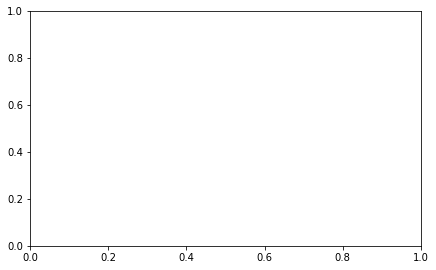

In [1]:
from HTGrid import *
from IPython.display import display
import inspect
from math import *

#for plotting in this notebook.
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
matplotlib.rc('animation', html='html5')
matplotlib.rcParams['image.cmap'] = 'jet'   #Set matshow colors to v 1.0 style
#set the plot aspect ratio and setup a default figure to use.
goldenratio=1/2*(1+sqrt(5)); fsx=7; fsy=fsx/goldenratio
MyFigure, MyAxes = plt.subplots(1,1,figsize=(fsx,fsy));

#Function to return the function name, parameters and doc string.
def InfoDocString(function):
    """Function to return function definition and document string."""
    
    code = inspect.getsource(function)
    docstring = inspect.getdoc(function)
    return code[0:code.find(':')+1].lstrip() +'\n' + docstring

# HTGrid Class Structure
The class HTGrid (Heat Transfer Grid) inherits functionality from CAGrid.  For a full description, consult [CA Numpy Inheritance](CA_Numpy_Inheritance.ipynb)  The code for HTGrid is below.

In [2]:
print(inspect.getsource(HTGrid.__new__))
print(inspect.getsource(HTGrid.Update))
print(inspect.getsource(HTGrid.SetBoundary))

    def __new__(cls,shape, *args, tau=0.2, **kwargs):

        ni=CAGrid.__new__(cls,shape, *args, **kwargs)
        ni.tau=tau
        return ni

    def Update(self):
        #Calculate T_left + T_top + T_right + T_bottom - 4 T_node
        numpy.place(self.count,self.TrueArray,0)
        self.count = self.count - 4 * self['T']
        for n in self.Neighbors:
            self.count = self.count + n['T']

        #Multiply by tau
        self.count = self.tau * self.count

        #Add value of deltaT (count) to current value
        self['T'] += self.count
        self.SetBoundary()

    def SetBoundary(self):

        # copy the rows and columns.  These are views into the base created in __new__
        #  This simulation assumes adiabatic (or reflective) walls.
        numpy.copyto(self.BBottomRow, self.BottomRow)
        numpy.copyto(self.BLeftColumn, self.LeftColumn)
        numpy.copyto(self.BTopRow, self.TopRow)
        numpy.copyto(self.BRightColumn, self.RightColumn)



# Tests
We will run a test of the code by starting with a random distribution of temperatures and running the simulation.  The temperatures should become uniform, and the total thermal energy should be a constant.
## Random Initial Conditions

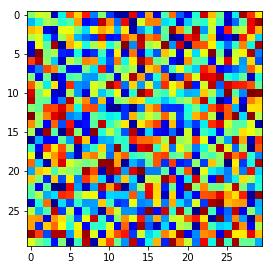

In [3]:
rows = 30; columns = 30; MyDtype = numpy.dtype([('T','f')]);
MyGrid=HTGrid((rows,columns),MyDtype, tau=.025)
setrandomT(MyGrid)
MyAxes.imshow(MyGrid['T'],vmin=0, vmax=100); MyFigure

Now we update and show the grid.

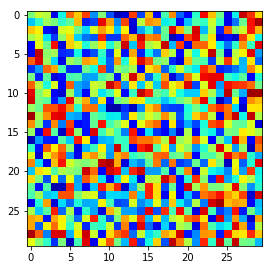

In [4]:
MyGrid.Update();MyAxes.imshow(MyGrid['T'],vmin=0, vmax=100); MyFigure

We will update and show the grid one more time.  The temperature profile is becoming uniform.

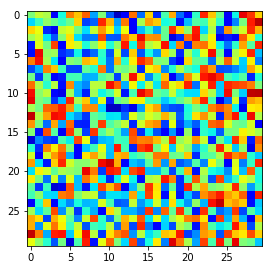

In [5]:
MyGrid.Update();MyAxes.imshow(MyGrid['T'],vmin=0, vmax=100); MyFigure

In [6]:
def af(n):
    MyGrid.Update()
    MyAxes.imshow(MyGrid['T'],vmin=0, vmax=100)

In [7]:
AnimationFrames = 70  #total number of frames in animation.
DelayBetweenFrames = 50 #in msec (20 gives 50 fps) (33.3 gives 30 fps)
AnimationTime = AnimationFrames * DelayBetweenFrames/1000
print ("The animation will be {:.1f} seconds long.".format(AnimationTime))

The animation will be 3.5 seconds long.


In [8]:
#MyAnimation = animation.FuncAnimation(MyFigure, af,
#                               frames=AnimationFrames, interval=DelayBetweenFrames, blit=False)
#MyAnimation.save('HT_Test_01.mp4',extra_args=['-vcodec', 'h264'])

<video controls autoplay loop src="HT_Test_01.mp4" />

## Gradient Initial Conditions
Let us look at a different set of initial conditions which will allow the heat transfer to progress a bit slower.

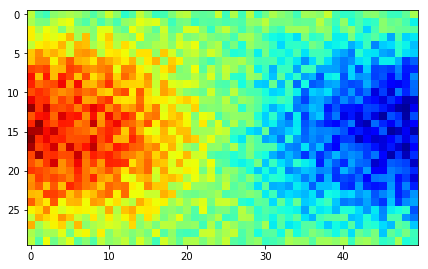

In [9]:
rows = 30; columns = 50; MyDtype = numpy.dtype([('T','f')]);
MyGrid=HTGrid((rows,columns),MyDtype, tau=.2)
for r in range(rows):
    for c in range(columns):
        MyGrid['T'][r][c] = sin(r/rows*pi)*cos(c/columns*pi)*40 + 40  + 20*numpy.random.random()
MyGrid.SetBoundary()
MyAxes.imshow(MyGrid['T'],vmin=0, vmax=100); MyFigure

In [10]:
AnimationFrames = 800  #total number of frames in animation.
DelayBetweenFrames = 20 #in msec (20 gives 50 fps) (33.3 gives 30 fps)
AnimationTime = AnimationFrames * DelayBetweenFrames/1000
print ("The animation will be {:.1f} seconds long.".format(AnimationTime))

The animation will be 16.0 seconds long.


### Warning
**The next cell takes a significant amount of time to complete.**  The process of sending frames to a renderer and having it convert that sequence of frames into a video file takes a lot of computational time.

In [11]:
#MyAnimation = animation.FuncAnimation(MyFigure, af,
#                               frames=AnimationFrames, interval=DelayBetweenFrames, blit=False)
#MyAnimation.save('HT_Test_02.mp4',extra_args=['-vcodec', 'h264'])

### Animation Result
The result of the above cell was saved externally so it could be embedded here.
<video controls autoplay loop src="HT_Test_02.mp4" />

### Graphical Display
The changes above are hard to fully understand and they take a significant amount of time to generate.  Here we will rerun the simulation and create a graph of the Temperature along the center of the plot.  

In [12]:
rows = 30; columns = 50; MyDtype = numpy.dtype([('T','f')]);
MyGrid=HTGrid((rows,columns),MyDtype, tau=.2)
for r in range(rows):
    for c in range(columns):
        MyGrid['T'][r][c] = sin(r/rows*pi)*cos(c/columns*pi)*40 + 40  + 20*numpy.random.random()
MyGrid.SetBoundary()
t=0

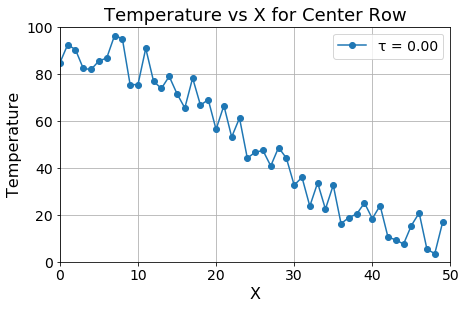

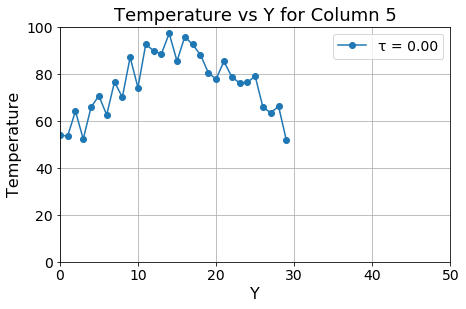

In [13]:
GTFigure, GTAxes = plt.subplots(1, 1);
GTAxes.plot(MyGrid["T"][15][:], '-o',label='τ = {:.2f}'.format(t));
GTAxes.set_xlabel('X');
GTAxes.set_ylabel('Temperature');
GTAxes.set_title('Temperature vs X for Center Row');
GTAxes.set_ylim(0,100); GTAxes.set_xlim(0,50)
format_plot(GTAxes,14)

ctp=5;  #Column to Plot
GTRFigure, GTRAxes = plt.subplots(1,1)
GTRAxes.plot(MyGrid["T"][:,ctp], '-o',label='τ = {:.2f}'.format(t));
GTRAxes.set_xlabel('Y');
GTRAxes.set_ylabel('Temperature');
GTRAxes.set_title('Temperature vs Y for Column {:.0f}'.format(ctp));
GTRAxes.set_ylim(0,100); GTRAxes.set_xlim(0,50)
format_plot(GTRAxes,14)

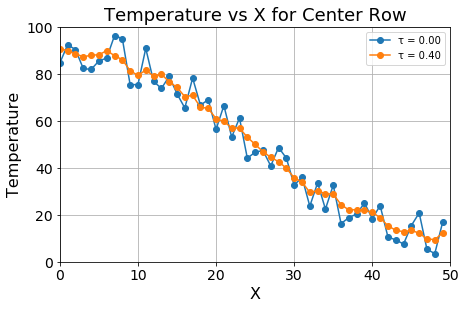

In [14]:
for i in range(2):
    MyGrid.Update()
    t+=MyGrid.tau
GTAxes.plot(MyGrid["T"][15][:], '-o',label='τ = {:.2f}'.format(t));
GTRAxes.plot(MyGrid["T"][:,ctp], '-o',label='τ = {:.2f}'.format(t));
GTAxes.legend(); GTFigure

Note in the above plot that the random fluctuations disappear very quickly.  This is because the random fluctuations have very large gradients.  Let us let it run a bit longer.

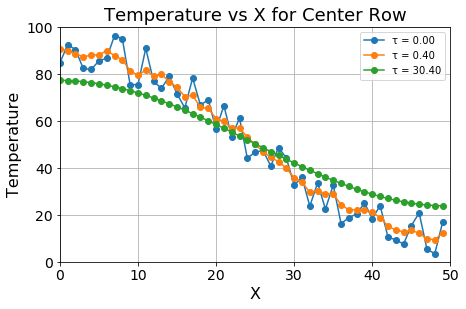

In [15]:
for i in range(150):
    MyGrid.Update()
    t+=MyGrid.tau
GTAxes.plot(MyGrid["T"][15][:], '-o',label='τ = {:.2f}'.format(t));
GTRAxes.plot(MyGrid["T"][:,ctp], '-o',label='τ = {:.2f}'.format(t));
GTAxes.legend(); GTFigure

Note that in the above plot, the boundary conditions are now becoming apparent.  There is no temperature gradient at the left and right walls.  This simulation employs an adiabatic or 'reflective' boundary conditions.  The zero gradient at the walls is because the walls do not allow heat flow in or out.

Below we include a few more plots to show the late time behavior.

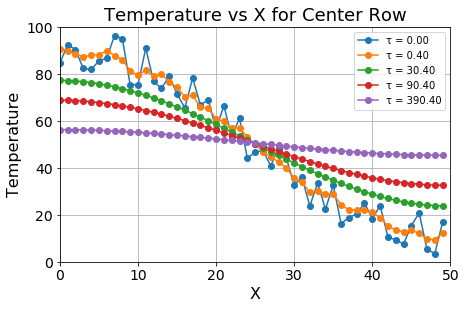

In [16]:
for i in range(300):
    MyGrid.Update()
    t+=MyGrid.tau
GTAxes.plot(MyGrid["T"][15][:], '-o',label='τ = {:.2f}'.format(t));
GTRAxes.plot(MyGrid["T"][:,ctp], '-o',label='τ = {:.2f}'.format(t));
for i in range(1500):
    MyGrid.Update()
    t+=MyGrid.tau
GTRAxes.plot(MyGrid["T"][:,ctp], '-o',label='τ = {:.2f}'.format(t));
GTAxes.plot(MyGrid["T"][15][:], '-o',label='τ = {:.2f}'.format(t));
GTAxes.legend(); GTFigure

As the time gets later, the temperature gradient becomes smaller and the heat transfer rate decreases.  While at time $\tau \simeq 400,$ there is still some temperature difference in the plate, it is not much.  Since the temperature difference is small, it will take a long time for this remaining difference to diffuse away.

The figure below shows the temperature profile along the 'y' axis or the first column.

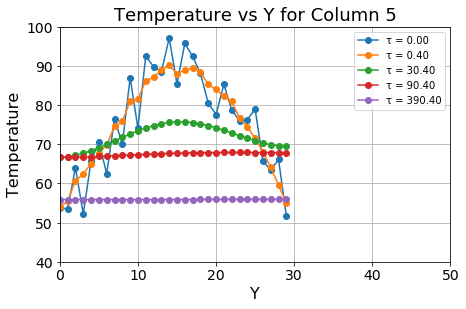

In [18]:
GTRAxes.set_ylim(40,100); GTRAxes.legend(); GTRFigure